In [1]:
# Evaluating met and parameter data to understand metabolic landscape
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
import pandas as pd
from sklearn.decomposition import PCA
import pickle as pkl
import random
from mpl_toolkits import mplot3d
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel as C

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# main_folder = "drive/My Drive/WHILO/Met Landscape/heart rate experiment/"

main_folder = "/content/drive/Shareddrives/Ability Lab/Simulating HILO/Code/"
data_path = main_folder + "allparams_edited.xlsx"
datasets = os.listdir(main_folder)
def adjust_by_day(data):
    len_data = data.shape[0]
    del_list = []
    for j in range(len_data): # go through npd and delete rows where met is 0
        if data[j,0] == 0.0:
            del_list.append(j)
    data = np.delete(data,del_list,0)
    len_data = data.shape[0]

    gen_cnt = np.unique(data[:,-2])#.astype(int)
    avg_offset = np.zeros(len(gen_cnt))
    for i,gen in enumerate(gen_cnt):
        cnt = 0
        off = 0
        for j in range(len_data):
            if (data[j,-2] == gen) and (data[j,-1] == 1.):
                #print(data[j,0])
                off += data[j,0]
                cnt += 1
        avg_offset[i] = off/cnt
    avg_offset = -1*(avg_offset - avg_offset[0])
    #print(avg_offset)
    corr_mets = np.zeros(len_data)
    for j in range(len_data):
        gen_ind = int(data[j,-2])-1
        corr_mets[j] = data[j,0] + avg_offset[gen_ind]
    return corr_mets

In [3]:
xls = pd.ExcelFile(data_path)
subjects = ['PAWN','PBPK','PCYC','PDUL','PEFM','EAON','EBOA','ECAZ','EDMM','EEPM']
mass = [54,67,75,74,72,69,93,59,82,72]
init_len = 10000
param_data = np.zeros((init_len,4))
param_norm_data = np.zeros((init_len,4)) # normalizing param 1 by weight
met_data = np.zeros(init_len)
ind = 0
subj_inds = np.zeros(len(subjects), dtype=int)
reopt_adj = []
for i in range(len(subjects)):
    del_list = []
    df = pd.read_excel(xls, i)
    npd = df[df.columns[0:5]].to_numpy()
    len_npd = npd.shape[0]
    for j in range(len_npd): # go through npd and delete rows where met is 0
        if npd[j,0] == 0.0:
            del_list.append(j)
    npd = np.delete(npd,del_list,0)
    len_npd = npd.shape[0]

    if i >= 5:
        full_data = df[df.columns[0:7]].to_numpy()
        corr_mets = adjust_by_day(full_data)
        reopt_adj.append(corr_mets)

    param_data[ind:ind+len_npd,:] = npd[:len_npd,1:]
    norm_vec = np.array([1/mass[i], 1., 1., 1.])
    param_norm_data[ind:ind+len_npd,:] = param_data[ind:ind+len_npd,:]*norm_vec
    met_data[ind:ind+len_npd] = npd[:len_npd,0]
    ind += len_npd
    subj_inds[i] = ind

param_data = param_data[:ind,:]
param_norm_data = param_norm_data[:ind,:]
met_data = met_data[:ind]
if np.sum(np.isnan(met_data)) > 0:
    for i in range(met_data.shape[0]):
        if np.isnan(met_data[i]):
            met_data[i] = met_data[i-1]

# add code to delete parts of array with 0 for metabolics
cont_opt_params = param_norm_data[:subj_inds[4],:]
cont_opt_met = met_data[:subj_inds[4]]
reopt_params = param_norm_data[subj_inds[4]:,:]
reopt_met = met_data[subj_inds[4]:]
#print(param_data.shape, met_data.shape, np.sum(np.isnan(met_data)))

PCA for continuing opt subjects:
[0.3558181  0.28063766 0.19561338 0.16793086] 4 components capture 100.0 % of total variation
[[-0.62968455 -0.45527962 -0.62937451  0.01027417]
 [ 0.12138061 -0.5083452   0.25954539  0.81208873]
 [ 0.46208392 -0.71112084  0.04348106 -0.5281051 ]
 [-0.61257045 -0.16915314  0.73118624 -0.24801481]]


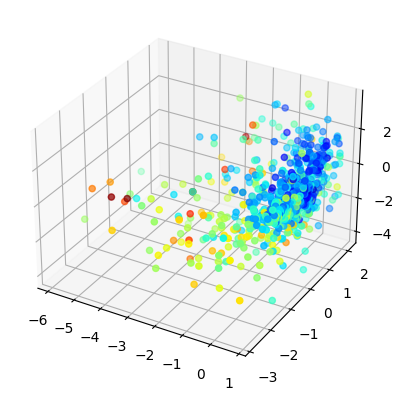

In [4]:
# PCA testing to see if the param dimensions can be reduced
n_comp = 4
pca = PCA(n_components = n_comp, svd_solver='full')
norm_data_mean = np.mean(cont_opt_params,axis=0)
norm_data_std = np.std(cont_opt_params,axis=0)
norm_data = (cont_opt_params - norm_data_mean)/norm_data_std
pca.fit(norm_data)#cont_opt_params)
print("PCA for continuing opt subjects:")
print(pca.explained_variance_ratio_, len(pca.explained_variance_ratio_),"components capture", np.round(np.sum(pca.explained_variance_ratio_),2)*100.0,"% of total variation")
cont_opt_pca = pca.components_
print(cont_opt_pca)
# Params are all fairly equally weighted

# n_comp = 3
# pca = PCA(n_components = n_comp, svd_solver='full')
# norm_reopt_data = (reopt_params - np.mean(reopt_params,axis=0))/np.std(reopt_params,axis=0)
# pca.fit(norm_reopt_data)
# print("PCA for reopt subjects:")
# print(pca.explained_variance_ratio_, len(pca.explained_variance_ratio_),"components capture", np.round(np.sum(pca.explained_variance_ratio_),2)*100.0,"% of total variation")
# reopt_pca = pca.components_

# visualize original data with 3 dimensions
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
subj_data = norm_data
subj_met = cont_opt_met
ax.scatter(subj_data[:,1],subj_data[:,2], subj_data[:,0],c=subj_met,cmap='jet',)
#ax.view_init(0, 90)
plt.show()

plt.rcParams.update({'font.size': 8})

In [5]:
from sklearn.linear_model import Ridge

# make 3x3 plotting structure w/ param range from 20 to 75 in P1 and 5 to 40 in P2
def plot_3d_grid(pca_data, met_data, subj_l):

    xmin = np.amin(pca_data[:subj_l[-1],0])
    xmax = np.amax(pca_data[:subj_l[-1],0])#75
    ymin = np.amin(pca_data[:subj_l[-1],1])#5
    ymax = np.amax(pca_data[:subj_l[-1],1])#40
    print(xmin, xmax, ymin, ymax)
    # visualizing cont opt subjects
    fig, ax = plt.subplots(4,3,figsize=(15,22.5))
    x_mean = np.mean(pca_data[subj_l[0]:,:],axis=0)
    x_std = np.std(pca_data[subj_l[0]:,:],axis=0)
    m_save_path = main_folder + 'save_GP/'
    np.save(m_save_path+'mean.npy',x_mean)
    np.save(m_save_path+'std.npy',x_std)
    print(x_mean, x_std)
    for i, end_ind in enumerate(list(subj_l[1:-1])):

        start_ind = subj_l[i]
        subj_spec = pca_data[start_ind:end_ind,:]
        subj_spec_met = met_data[start_ind:end_ind]
        #print(subj_spec.shape, subj_spec_met.shape)
        # Data for a three-dimensional line
        z = np.linspace(len(subj_spec[:,0])-1,0,len(subj_spec[:,0]))
        z2 = subj_spec_met - np.amin(subj_spec_met)
        z2 = (z2 - np.mean(z2))/np.std(z2)
        x = subj_spec[:,0]
        y = subj_spec[:,1]

        kernel = C() + RBF() + WhiteKernel()
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        #x_mean = np.mean(subj_spec,axis=0)
        #x_std = np.std(subj_spec,axis=0)
        x_train = (subj_spec - x_mean)/x_std
        gp.fit(x_train, z2)
        print(gp.kernel_)
        # setting up grid contour of space
        numpts = 100
        xc = np.linspace(xmin, xmax, numpts)
        yc = np.linspace(ymin, ymax, numpts)
        X,Y = np.meshgrid(xc,yc)
        output,std = gp.predict(x_train, return_std = True)
        Z = [gp.predict((np.array([i[:],j[:]]).transpose()-x_mean)/x_std, return_std = False) for (i,j) in zip(X,Y)] #gp.predict(np.array([[i,j]]))

        # POINT AND CONTOUR PLOT
        ct = ax[i,0].contour(X,Y,Z,levels=np.linspace(np.amin(z2),np.amax(z2),50),cmap='jet')
        sc = ax[i,0].scatter(x,y,c=z2,cmap = 'jet')
        cbar = fig.colorbar(sc, ax=ax[i,0])
        ax[i,0].set_ylabel('PCA Parameter 2')
        ax[i,0].set_xlabel('PCA Parameter 1')
        ax[i,0].set_ylim([ymin, ymax])
        ax[i,0].set_xlim([xmin, xmax])
        cbar.set_label('Metabolic cost above optimal (W)')

        # STD PLOT
        Zstd = [gp.predict((np.array([a[:],b[:]]).transpose()-x_mean)/x_std, return_std = True)[1] for (a,b) in zip(X,Y)] #gp.predict(np.array([[i,j]]))
        ct = ax[i,1].contour(X,Y,Zstd,levels=np.linspace(np.amin(Zstd),np.amax(Zstd),50),cmap='jet')
        #sc = plt.scatter(x,y,c=z2,cmap = 'jet')
        stdbar = fig.colorbar(ct, ax=ax[i,1])
        #ax[i,1].set_ylabel('PCA Parameter 2')
        ax[i,1].set_xlabel('PCA Parameter 1')
        stdbar.set_label('Standard deviation in estimates')

        print(np.array(Z).shape, np.array(Zstd).shape)
        Z_obj = np.array(Z) + np.exp((np.array(Zstd)*5.3))
        # OBJ FUNCT PLOT
        ct2 = ax[i,2].contour(X,Y,list(Z_obj),levels=np.linspace(0,250.0,50),cmap='jet')
        #sc = plt.scatter(x,y,c=z2,cmap = 'jet')
        stdbar = fig.colorbar(ct2, ax=ax[i,2])
        #ax[i,2].set_ylabel('PCA Parameter 2')
        ax[i,2].set_xlabel('PCA Parameter 1')
        stdbar.set_label('Objective function (W)')

        model_save_path = main_folder + 'save_GP/m'+str(i)+'.dump'
        with open(model_save_path, 'wb') as f:
            pkl.dump(gp,f)

    plt.show()


from mpl_toolkits.axes_grid1 import make_axes_locatable
# pass in nomalized params [samples, dims] and normalized metabolics [samples]
# outputs number of plots of the gaussian process fit along different axes
def plot_grid(params, met, subj_l, axis_inds = np.array([[0,1],[1,2],[2,3],[3,4]]), kernel=C()+RBF()+WhiteKernel(), n_restarts=10):
    param_min = np.amin(params, axis=0)-0.4
    param_max = np.amax(params, axis=0)+0.4
    numpts = 30
    param_pts = np.linspace(param_min, param_max, numpts) # [numpts, dims]
    param_labels = ['Peak torque', 'Peak time', 'Rise time', 'Fall time']
    # visualizing cont opt plots on grid [subjects, plots]
    fig, ax = plt.subplots(len(subj_l)-1,(axis_inds.shape[0])+1,figsize=(8,8), gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.5]}) # , gridspec_kw={'wspace': 0.4, 'hspace': 0.4}.  #2*axis_inds.shape[0],3*(len(subj_l)-1)))
    print("len(subj_l)-1 = ", len(subj_l)-1, "\naxis_inds.shape[0] = ", axis_inds.shape[0])
    for i, end_ind in enumerate(list(subj_l[1:])):
        start_ind = subj_l[i]
        subj_params = params[start_ind:end_ind,:]
        subj_met = met[start_ind:end_ind]
        # GP MODEL
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts)#, optimizer=None)
        gp.fit(subj_params, subj_met)
        # Saving GP
        model_save_path = main_folder + 'save_GP/'+str(kernel)+'/'
        if not os.path.exists(model_save_path):
            os.makedirs(model_save_path)
        with open(model_save_path + 'm'+str(i)+'.dump', 'wb') as f:
            pkl.dump(gp,f)
        # LR MODEL
        # lr = Ridge()
        # poly = PF(2)
        # new_train = poly.fit_transform(subj_params)
        # lr.fit(new_train, subj_met)

        # Visualize different cross sections of the data
        #for j in range(axis_inds.shape[0]):
        for j in range(axis_inds.shape[0]+1):
          if j == axis_inds.shape[0]:
            ax[i,j].axis('off')
            cbar = fig.colorbar(sc, ax=ax[i,j])
            cbar.set_label('Normalized\nmetabolic cost')
          else:
            x,y = axis_inds[j]
            X,Y = np.meshgrid(param_pts[:,x],param_pts[:,y])
            test_slice = np.zeros((numpts,params.shape[1]))
            Z = []
            for (r,p) in zip(X,Y):
                test_slice[:,x] = r
                test_slice[:,y] = p
                pred_slice_ij = gp.predict(test_slice, return_std = False)
                # poly = PF(2)
                # new_test = poly.fit_transform(test_slice)
                # pred_slice_ij = lr.predict(new_test)
                Z.append(pred_slice_ij)
            # Data for a scatter
            z_data = subj_met
            x_data = subj_params[:,x]
            y_data = subj_params[:,y]
            # POINT AND CONTOUR PLOT
            ct = ax[i,j].contour(X,Y,Z,levels=np.linspace(np.amin(z_data),np.amax(z_data),numpts),cmap='jet',linewidths=1)
            sc = ax[i,j].scatter(x_data,y_data,c=z_data,cmap = 'jet',s=10)

            #cbar2 = fig.colorbar(ct, ax=ax[i,j])
            ax[i,j].set_ylabel(param_labels[y], labelpad=0.2)
            ax[i,j].set_xlabel(param_labels[x], labelpad=2)
            ax[i,j].set_ylim([param_min[y], param_max[y]])
            ax[i,j].set_xlim([param_min[x], param_max[x]])
            ax[i,j].set_yticks([], minor=False)
            ax[i,j].set_yticklabels([], minor=False)
            ax[i,j].set_xticks([], minor=False)
            ax[i,j].set_xticklabels([], minor=False)
            # if j == axis_inds.shape[0]-1: # last one so plot the colorbar label
            #     #cbar = fig.colorbar(sc, ax=ax[i,j])
            #     #cbar.set_label('Normalized\nmetabolic cost')
            #     # Move the color bar scales further to the right
            #     divider = make_axes_locatable(ax[i, j])
            #     cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and pad as needed
            #     cbar = plt.colorbar(sc, cax=cax)
            #     cbar.set_label('Normalized\nmetabolic cost')

    rows = ['Subject {}'.format(row) for row in ['1', '2', '3', '4', '5']]
    pad=5
    for a, row in zip(ax[:,0], rows):
        a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0), xycoords=a.yaxis.label, textcoords='offset points',fontsize=11, va='center', ha='right', rotation=90)

    # Adjust the layout to remove the plot area for the right-most subplots
    fig.subplots_adjust(right=0.95)  # Adjust as needed to ensure only the color bar scale is shown
    fig.tight_layout(pad=1.0)
    filename = "Fig4_ZK_subj_modeling_3"
    plt.savefig(main_folder+'plots/'+filename+".pdf", bbox_inches = 'tight', dpi=900, pad_inches = 0)
    plt.savefig(main_folder+'plots/'+filename+".svg", bbox_inches = 'tight', dpi=900, pad_inches = 0)
    #plt.savefig(main_folder+'plots/'+filename+".eps", bbox_inches = 'tight', dpi=600, pad_inches = 0)
    plt.savefig(main_folder+'plots/'+filename+".png", bbox_inches = 'tight', dpi=900, pad_inches = 0)

    plt.show()

def save_vars(model_path, var_list, var_names):
    for i, varn in enumerate(var_names):
        np.save(model_path + varn + '.npy', var_list[i])
    print("Done saving.")

# # Reformat the data based on PCA plots
# pca_data = np.matmul(param_data, cont_opt_pca.transpose())
# subj_r = np.insert(subj_inds,0,0)
# met_mean = np.mean(cont_opt_met)
# met_std = np.std(cont_opt_met)
# norm_met = (cont_opt_met - met_mean)/met_std

# axis_inds = np.array([[0,1],[1,2],[2,3],[3,0]])
# kernel = C() + WhiteKernel() + Matern(nu=0.5) #RBF()
# n_restarts = 5
# params = norm_data
# met = norm_met
# subj_l = subj_r[:6]
# var_list = [params, norm_data_mean, norm_data_std, norm_met, met_mean, met_std, subj_l]
# var_names = ['norm_params','param_mean','param_std','norm_met','met_mean','met_std','subj_inds']
# model_save_path = main_folder + 'save_GP/_data/'
# save_vars(model_save_path, var_list, var_names)

# #plot_grid(norm_data, norm_met, subj_r[:6], axis_inds, kernel, n_restarts)

In [6]:
# Reformat the data based on PCA plots
pca_data = np.matmul(param_data, cont_opt_pca.transpose())
subj_r = np.insert(subj_inds,0,0)
met_mean = np.mean(cont_opt_met)
met_std = np.std(cont_opt_met)
norm_met = (cont_opt_met - met_mean)/met_std

axis_inds = np.array([[0,1],[1,2],[2,3],[3,0]])
kernel = C() + WhiteKernel() + Matern(nu=0.5) #RBF()
n_restarts = 5
params = norm_data
met = norm_met
subj_l = subj_r[:6]
var_list = [params, norm_data_mean, norm_data_std, norm_met, met_mean, met_std, subj_l]
var_names = ['norm_params','param_mean','param_std','norm_met','met_mean','met_std','subj_inds']
model_save_path = main_folder + 'save_GP/_data/'
save_vars(model_save_path, var_list, var_names)

#plot_grid(norm_data, norm_met, subj_r[:6], axis_inds, kernel, n_restarts)

Done saving.


len(subj_l)-1 =  5 
axis_inds.shape[0] =  4


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


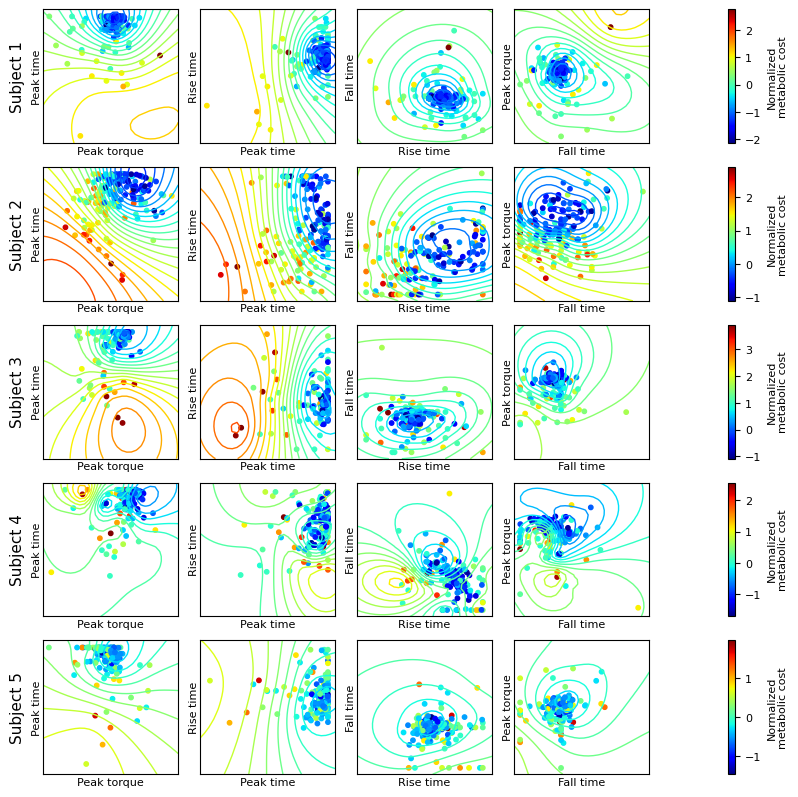

In [7]:
plot_grid(norm_data, norm_met, subj_r[:6], axis_inds, kernel, n_restarts)

In [8]:
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.gaussian_process.kernels import RationalQuadratic
# Validating surrogate models
models_path = main_folder + 'save_GP/'
kernels = ['LR','LR Poly',C() + RBF() + WhiteKernel(),C()+WhiteKernel()+Matern(), C()+WhiteKernel()+Matern(nu=0.5), C()+WhiteKernel()+RationalQuadratic()]#, C()+Matern()+WhiteKernel()]#, C() + RBF() + WhiteKernel(), C() + Matern(), C() + Matern() + WhiteKernel()] # add all lists to validate and visualize
# len_list = [0.1,0.4,1.0,5.0,10.0, 0.01, 0.02, 0.03, 0.06, 0.2]
# WN_list = [0.17, 0.2, 0.22]
# nu_list = [0.5]#,1.5,2.5]
# for i, l in enumerate(len_list):
#     for j in WN_list:
#         for k in nu_list:
#             kernels.append(C()+WhiteKernel(noise_level=j)+Matern(nu=k, length_scale = l))
num_gps = 5 # number of gps trained for the different subjects
b_tests = 30 # number of bootstrap tests to perform
err_mat = np.zeros((len(kernels), num_gps, b_tests)) # error (mape) of shape [models, tests, samples]
n_restarts = 5 # for setting up GP

def bootstrap_set(data_size): # returns train, test inds
    train = [random.sample(range(data_size), 1)[0] for i in range(data_size)]
    test = list(set(range(data_size)) - set(train))
    return test, train

for i, kern in enumerate(kernels):
    np.random.seed = 1
    random.seed(1)
    print("Method number:",i)
    for j, end_ind in enumerate(subj_l[1:1+num_gps]):
        print("J:",j)
        # sample to re-load the GPs
        start_ind = subj_l[j] #ISSUE HERE
        subj_data = params[start_ind:end_ind,:]
        subj_met = met[start_ind:end_ind]
        len_data = subj_data.shape[0]
        for k in range(b_tests):
            test_inds, train_inds = bootstrap_set(len_data)
            if i == 0:
                lr = Ridge()
                lr.fit(subj_data[train_inds,:], subj_met[train_inds])
                pred_boot = lr.predict(subj_data[test_inds,:]) # input size [samples, dim]
                pred_full = lr.predict(subj_data)
            elif i == 1:
                lr = Ridge()
                poly = PF(2)
                new_train = poly.fit_transform(subj_data[train_inds,:])
                lr.fit(new_train, subj_met[train_inds])
                new_boot = poly.fit_transform(subj_data[test_inds,:])
                new_full = poly.fit_transform(subj_data)
                pred_boot = lr.predict(new_boot) # input size [samples, dim]
                pred_full = lr.predict(new_full)
            else:
                gpn = GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=n_restarts)#, optimizer=None)
                gpn.fit(subj_data[train_inds,:], subj_met[train_inds]) # fit gp to train data
                pred_boot = gpn.predict(subj_data[test_inds,:], return_std = False) # input size [samples, dim]
                pred_full = gpn.predict(subj_data, return_std = False)
                #print(gpn.kernel_)
            #print(pred_boot[:5], subj_met[test_inds[:5]])
            err_pred = abs(pred_boot - subj_met[test_inds])#**2
            err_full = abs(pred_full - subj_met)#**2
            #print(np.mean(np.sqrt(err_pred)),np.mean(np.sqrt(err_full)))
            err_mat[i,j,k] = (0.632*(np.mean(err_pred)) + 0.368*(np.mean(err_full)))/(np.ptp(subj_met))*100. # MAPE based on half the range

Method number: 0
J: 0
J: 1
J: 2
J: 3
J: 4
Method number: 1
J: 0
J: 1
J: 2
J: 3
J: 4
Method number: 2
J: 0


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420

J: 1
J: 2
J: 3


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420

J: 4


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: 

Method number: 3
J: 0


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420

J: 1
J: 2
J: 3


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420

J: 4


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420

Method number: 4
J: 0


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420

J: 1
J: 2
J: 3


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420

J: 4


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420

Method number: 5
J: 0


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420

J: 1


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


J: 2


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


J: 3


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420

J: 4


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420

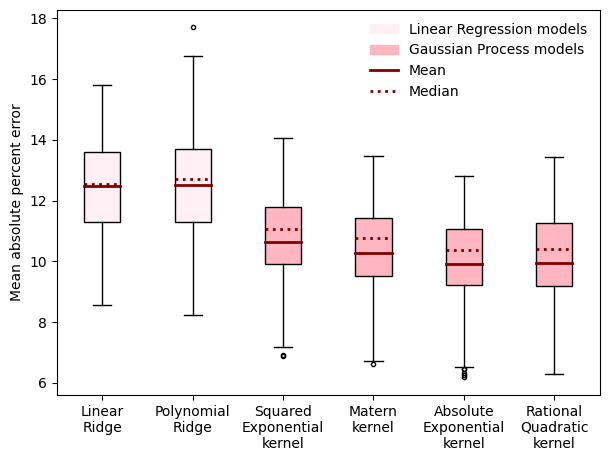

In [22]:
# @title Plot surrogate model performance

import matplotlib.colors as mcolors
model_labels = ['Linear\nRidge','Polynomial\nRidge','Squared\nExponential\nkernel','Matern\nkernel','Absolute\nExponential\nkernel', 'Rational\nQuadratic\nkernel']
plt.rcParams.update({'font.size': 10})
err_mat_re = np.reshape(err_mat, (len(kernels), -1))
np.save(model_save_path+'hyper_param_opt.npy', err_mat_re)
# fig, ax = plt.subplots(figsize=(3.5,3.5)) # box plot figure
fig, ax = plt.subplots(figsize=(7,3.5), frameon=False) # box plot figure

myflierprops = dict(marker='.')
mymedianprops = dict(linestyle=':', color='maroon', linewidth=2)
#meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
mymeanlineprops = dict(linestyle='-', color='maroon', linewidth=2)
# Specify colors for the boxes
  # Define color names
color_names = ['lavenderblush', 'lavenderblush', 'lightpink', 'lightpink', 'lightpink', 'lightpink']
  # Convert color names to RGBA format
box_colors = [mcolors.to_rgba(color) for color in color_names]

# Plot the boxplot with colors and legend
box = ax.boxplot(err_mat_re.transpose(), showmeans=True, meanline=True, showfliers=True, flierprops=myflierprops,
                 medianprops=mymedianprops, meanprops=mymeanlineprops, patch_artist=True, widths=0.4)
# box = ax.boxplot(err_mat_re.transpose(), showmeans=True, meanline=True, showfliers=True, flierprops=myflierprops,
#                 medianprops=mymedianprops, meanprops=mymeanlineprops, patch_artist=True,
#                 boxprops=dict(facecolor=box_colors))

# fill with colors
for patch, color in zip(box['boxes'], color_names):
  patch.set_facecolor(color)

# Set legend
legend_labels = ["Linear Regression models", "Gaussian Process models"]
legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['lavenderblush', 'lightpink']]
legend_handles.extend([plt.Line2D([0], [0], color='maroon', linestyle='-', linewidth=2),  # Mean
                       plt.Line2D([0], [0], color='maroon', linestyle=':', linewidth=2)])  # Median
legend_labels.extend(["Mean", "Median"])
ax.legend(legend_handles, legend_labels, frameon=False)

ax.set_xticklabels(model_labels)
#ax.set_xlabel('Models')
ax.set_ylabel('Mean absolute percent error')

# Hide top and right spines
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

filename = "Fig3_ZK_model_val8"
# Saving the plot
plt.savefig(main_folder+'plots/'+filename+".pdf", bbox_inches='tight', dpi=900, pad_inches=0)
plt.savefig(main_folder+'plots/'+filename+".svg", bbox_inches='tight', dpi=900, pad_inches=0)
# plt.savefig(main_folder+'plots/'+filename+".eps", bbox_inches='tight', dpi=600, pad_inches=0)
plt.savefig(main_folder+'plots/'+filename+".png", bbox_inches='tight', dpi=900, pad_inches=0)
plt.show()

In [ ]:
# gp = pkl.load(open(main_folder + 'save_GP/' + m + '/m'+str(j)+'.dump','rb'))
# print(gp.kernel_)

# visualizing reopt subjects
# def plot_3d(subj_spec, subj_spec_met):
#     # Data for a three-dimensional line
#     z = np.linspace(len(subj_spec[:,0])-1,0,len(subj_spec[:,0]))
#     z2 = subj_spec_met - np.amin(subj_spec_met)
#     x = subj_spec[:,0]
#     y = subj_spec[:,1]
#     plt.figure()
#     sc = plt.scatter(x,y,c=z2,cmap = 'jet')
#     cbar = plt.colorbar(sc)
#     plt.ylabel('PCA Parameter 2')
#     plt.xlabel('PCA Parameter 1')
#     cbar.set_label('Metabolic cost above optimal (W)')
#     plt.show()

# repca_data = np.matmul(param_data, reopt_pca.transpose())
# for i, end_ind in enumerate(list(subj_l[6:])):
#     start_ind = subj_l[i+5]
#     subj_spec = repca_data[start_ind:end_ind,:]
#     subj_spec_met = met_data[start_ind:end_ind]
#     print(subj_spec_met.shape, len(reopt_adj[i]))
#     plot_3d(-1.*subj_spec, subj_spec_met)
#     plot_3d(-1.*subj_spec, reopt_adj[i])